In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

from tensorboardX import SummaryWriter
from MLDataTools.image_normalization import RandomDihedral
from skimage.external import tifffile as tiff
import numpy as np
from matplotlib import pyplot
import shutil
%matplotlib inline

# torch setup
torch.set_default_tensor_type(torch.DoubleTensor) # so it doesnt throw a incompatible type exception
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # important for cloud compatability

In [2]:
# tensorboard setup
from datetime import datetime
date = datetime.now().strftime("%Y-%m-%d.%H:%M:%S")

writer = SummaryWriter('tensorboardx/ResNet50_'+date)

## Constant definitions and global variables


In [3]:
EPOCHS = 10
NUM_CLASSES = 4
ARCH = 'ResNet18'
RESUME_TRAINING = False

global_step = 0
has_visualised = False
best_accuracy = 0.

## Data loading and pre-processing

In [4]:
class AddDimension:
    def __init__(self, init_fn=torch.zeros):
        self.init_fn = init_fn
        
    def __call__(self, sample):
        size = sample.shape[-1] # assuming image is square with dims Channels x Width x Height
        zeros = self.init_fn(1, size, size)
        return torch.cat((sample, zeros))
    
# avoids a pytorch error: negative strides not supported in .from_numpy
class ToTensorCopy:
    def __call__(self,sample):
        return torch.from_numpy(sample.copy())
    
class Denormalize:
    def __init__(self, means, stdev):
        self.means = means
        self.stdev = stdev
    def __call__(self, sample):
        for dim in range(3):
            sample[dim].mul_(self.stdev[dim]).add_(self.means[dim])
        return sample

class GetInfo: # useful for debugging
    def __init__(self, label=None):
        self.label = label
    def __call__(self, sample):
        try:
            print(sample.shape)
        except: pass
        finally:
            if self.label: print(self.label)
            print(type(sample))
            return sample

In [5]:
resnet_mean, resnet_stdev = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225] # visualize the images with this normalization

ds_transforms = transforms.Compose([
    RandomDihedral(), # doing this first gets rid of the negative stride error in .from_numpy
    ToTensorCopy(),
    AddDimension(torch.zeros),
    transforms.Normalize(mean=resnet_mean,
                         std=resnet_stdev),
])
# use this for saving images later
denormalize = Denormalize(means=resnet_mean,
                     stdev=resnet_stdev)

In [6]:
# lets us control the datatype when the image is being read
def tiff_read(path: str):
    image = tiff.imread(path).astype(np.double)
    return image

In [7]:
BATCH_SIZE = 40
DATA_ROOT = '../datasets/yeast_ready'
trainset = torchvision.datasets.ImageFolder(DATA_ROOT+'/train', transform=ds_transforms, loader=tiff_read)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

testset = torchvision.datasets.ImageFolder(DATA_ROOT+'/test', transform=ds_transforms, loader=tiff_read)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# invert class_to_id
idx_to_class = {v:k for k,v in trainset.class_to_idx.items()}

## Model definition

In [8]:
net = models.resnet18(num_classes=NUM_CLASSES).to(device)

In [9]:
class SoftMax

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

## Training and testing procedures

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [ ]:
def save_checkpoint(state, is_best, filename=f'{ARCH}.checkpoint.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, f'{ARCH}.best.tar')

In [10]:
def visualise(images: torch.Tensor,targets: torch.Tensor, denorm, num_images=2): # data[variable_len, 3, 224, 224]
    for i in range(num_images):
        image = images[i].clone()
        image = denorm(image).numpy()
        figure, subplot, axes = tiff.imshow(image)
        idx = targets[i].item()
        c = idx_to_class[idx]
        figure.suptitle(f'Images in the training data set, class: {c}', fontsize=15)
        pyplot.show()


In [11]:
def train(epoch):
    net.train() # affects only modules like Dropout
    trainiter = iter(trainloader)
    for batch_idx, (data, targets) in enumerate(trainiter, 0):
        # visualize the data
        global has_visualised
        if not has_visualised: 
            visualise(data, targets, denormalize)
            has_visualised = True
            
        # get the inputs
        data, targets = data.to(device), targets.to(device)
        l = data.size(0)

        # backprop
        optimizer.zero_grad() # dont forget to do that
        output = net(data)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        scheduler.step(loss)
        
        # tensorboard
        global global_step
        global_step += 1
        writer.add_scalar('Train_Loss', loss.data.item(), global_step)
        if batch_idx % 2 == 0: # every 2nd batch add to our embedding writer
            #targets = targets.type(torch.DoubleTensor)
            writer.add_embedding(output, metadata=targets.data, label_img=data.data, global_step=global_step)
        if batch_idx % 20 == 0:
            samples_done = batch_idx * BATCH_SIZE
            percent = 100. * samples_done / len(trainloader.dataset)
            print(f"Train Epoch: {epoch} [{samples_done}/{len(trainloader.dataset)} "
                  f"({percent:3.3}%)]\tLoss: {loss.item():10.5}")
        

In [12]:
def test(epoch): # include one-time visualization to check that the images are ok
    with torch.no_grad():
        net.eval()
        test_loss = 0
        wcases = [] # list of worst cases
        classes_correct = list(0 for i in range(NUM_CLASSES))
        classes_total = list(0 for i in range(NUM_CLASSES))
        
        for data, targets in iter(testloader):
            # NOTE: UPDATE THIS LINE WHEN TORCH VERSION == 0.4
            data, targets = data.to(device), targets.to(device)
            
            output = net(data)
            
            # errors is a top 2 List[error:float, index of sample:int]
            new_cases = worst_cases(output, targets)  
            wcases.extend(new_cases)
            
            # sum up batch loss
            test_loss += criterion(output, targets).item()
            
            # get the index of the max log-probability
            _, pred = output.max(1) # returns a tuple the last element is the index Tensor
            c = (pred == targets).squeeze()
            l = c.size(0) # to account for different batch sizes
            # this helps to identify which classes the network is struggling with
            for i in range(l):
                label = targets[i].item()
                classes_correct[label] += c[i].item()
                classes_total[label] += 1
                        
        writer.add_scalar('Test_Loss', test_loss, epoch)
        test_loss /= len(testloader.dataset)
        accuracy = 100. * (sum(classes_correct) / sum(classes_total))
        # models saving
        if accuracy > best_accuracy:
            is_best = True
            best_accuracy = accuracy
        else: is_best = False
        
        save_checkpoint({
            'epoch': epoch + 1,
            'arch': ARCH,
            'state_dict': net.state_dict(),
            'optimizer' : optimizer.state_dict(),
        }, is_best)
        
        writer.add_scalar('Test_Accuracy',accuracy,global_step=epoch)
        print(f"\nTest set: Average loss: {test_loss:6.5}, Accuracy: {accuracy:10.5}%\n")
        
        # prints out accuracy per class
        for i, total, correct in zip(range(NUM_CLASSES), classes_total, classes_correct):
            cl = idx_to_class[i]
            cl_accuracy = 100. * (classes_correct[i] / classes_total[i])
            print(f"class [{cl}]: accuracy {cl_accuracy:10.4}%")
            
        # saves worst cases to tensorboard
        for image, label in wcases[:5]: # List[image:np.array, class:str]
                # should be of dimensions (3, 200, 200)
                denorm_image = denormalize(image)
                writer.add_image(label, denorm_image, epoch)

In [13]:
# helps to identify which cases the network was really wrong about
def worst_cases(data: torch.Tensor, targets: torch.Tensor, output: torch.Tensor, top=2):
    assert output.size(0) == targets.size(0)
    length = output.size(0)
    errors = []
    for i in range(length):
        z = torch.zeros(NUM_CLASSES)
        label = targets[i].item()
        z[label] = 1
        diff = (output[i] - z).numpy().copy()
        diff = np.sum(np.abs(diff))
        errors.append((diff, i))
        
    errors.sort(key=lambda x: x[0], reverse=True)

    for error, idx in errors[:top]: # append two new worst cases
            target = targets[idx].data.item()
            label = f"{idx_to_class[target]}_{error:4.4}"
            tensor = data[idx]
            wcases.append((tensor, label))
            
    return wcases

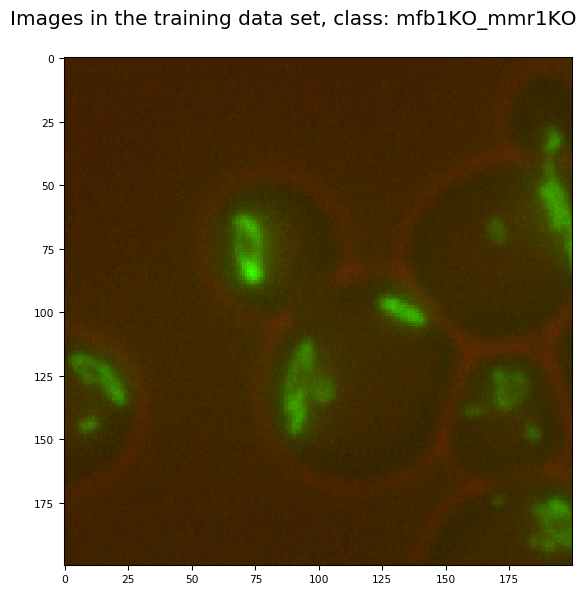

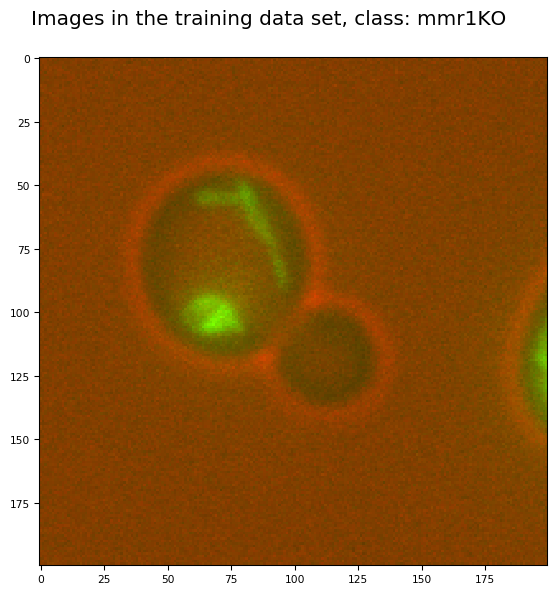

KeyboardInterrupt: 

In [14]:
for i in range(EPOCHS):
    train(i)
    test(i)
    
print("\n Finished training.")